# MIMIC 3 Dataset

In [1]:
import pandas as pd 
import pyspark
import numpy as np
import matplotlib.pyplot as plt

## utils 
import cleaning_utils

In [2]:
## read the datasets 

raw_dir = 'data/raw/'

patients = pd.read_csv(raw_dir + 'PATIENTS.csv')
admissions = pd.read_csv(raw_dir + 'ADMISSIONS.csv')
diagnosis = pd.read_csv(raw_dir + 'DIAGNOSES_ICD.csv')

In [3]:
from cleaning_utils import standardise_col_names

In [4]:
## Run basic column cleaning for dfs 

patients = standardise_col_names(patients)
admissions = standardise_col_names(admissions)
diagnosis = standardise_col_names(diagnosis)

In [5]:
## Check 
patients.columns

Index(['row_id', 'subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
       'expire_flag'],
      dtype='object')

### 1. Patients

* Cols: subject ID, gender, date of birth, date of death, dead of death recorded in hospital records, date of death from Social Security records, expire flag (death indicator at discharge: 1 for dead, 0 for alive at discharge)

* Expire flag helps with mortality analysis

* Data has been deidentified: dates are shifted to provide privacy, relative intervals are kept in tact

In [6]:
patients.head()

,row_id,subject_id,gender,dob,dod,dod_hosp,dod_ssn,expire_flag
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


In [7]:
## consolidating the three DOD columns

## explore 
DOD_cols = [col for col in patients.columns if col.startswith('dod')]
print(DOD_cols)
patients[patients[DOD_cols].notna().any(axis = 1)][DOD_cols]

## method: prioritise the DOD_HOSP column, then fill missing with DOD_SNN and DOD 


['dod', 'dod_hosp', 'dod_ssn']


,dod,dod_hosp,dod_ssn
1,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN
7,2121-07-08 00:00:00,2121-07-08 00:00:00,2121-07-08 00:00:00
10,2102-06-29 00:00:00,2102-06-29 00:00:00,2102-06-29 00:00:00
12,2168-06-13 00:00:00,2168-06-13 00:00:00,NaN
17,2198-02-18 00:00:00,2198-02-18 00:00:00,NaN
...,...,...,...
46497,2201-01-14 00:00:00,2201-01-14 00:00:00,2201-01-14 00:00:00
46504,2156-01-07 00:00:00,NaN,2156-01-07 00:00:00
46505,2127-08-07 00:00:00,2127-08-07 00:00:00,NaN
46513,2114-02-20 00:00:00,2114-02-20 00:00:00,2114-02-20 00:00:00


In [8]:
## Clean patients 
patients = cleaning_utils.convert_to_time_patients(patients)
patients_cleaned = cleaning_utils.handle_DOD_columns(patients)


object
datetime64[ns]
object
datetime64[ns]
object
datetime64[ns]
object
datetime64[ns]
['dod', 'dod_hosp', 'dod_ssn']
Dropping DOD cols


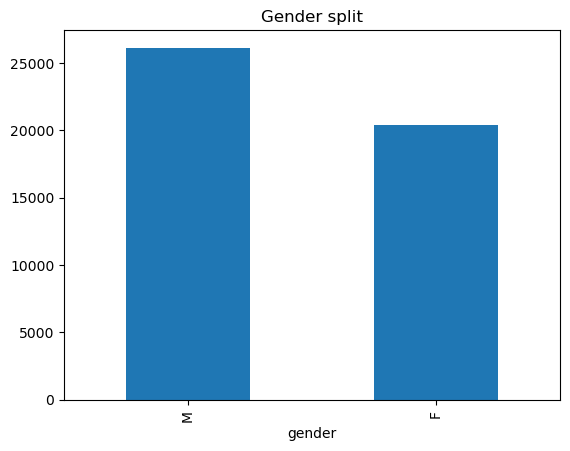

In [9]:
## Gender split 
patients.gender.value_counts().plot(kind = 'bar', title = 'Gender split')
plt.show()

There is a higher proportion of makes

In [10]:
## Get age 

patients_cleaned = cleaning_utils.get_age_via_extraction(patients_cleaned,
                       # .loc[patients_cleaned['EXPIRE_FLAG'] == 1], 
                       'DOD_consolidated', 'dob', 'age_at_death')


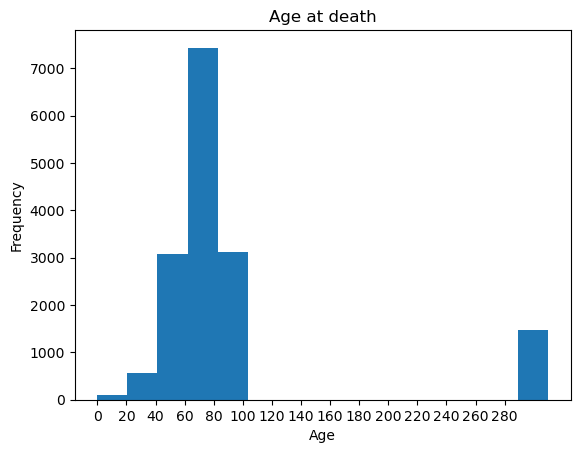

In [11]:
patients_cleaned.age_at_death.plot(kind = 'hist', title = 'Age at death', xlabel = 'Age', 
                                  bins = 15)
## add more x axis ticks
plt.xticks(range(0, 300, 20))

plt.show()

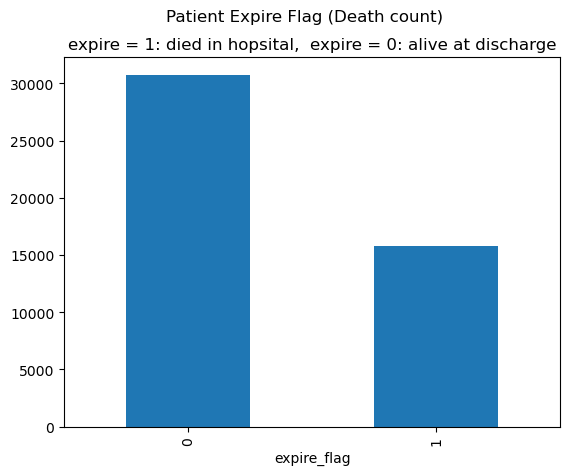

In [12]:
## Expire flag 
patients_cleaned.expire_flag.value_counts().plot(kind = 'bar', title = 'expire = 1: died in hopsital,  expire = 0: alive at discharge')
plt.suptitle('Patient Expire Flag (Death count)')
plt.show()

A very large number that are between 60 and 80, and mostly above 40. 

Most (double) also are alive at discharge

#### Sanity check

In [13]:
## Check 

## Patients with expire flag == 1: are all DODs entries filled for them?
def detect_DOD_missing(patients_cleaned):
    '''
    checking if there are patients that have passed away (expire flag == 1) that have no consolidated DOD
    '''
    missing_DOD = patients_cleaned[patients_cleaned.expire_flag == 1].DOD_consolidated.isna().sum()
    if missing_DOD > 0:
        print('There are missing DOD dates for patients who have expire flag == 1')
    else:
        print('No missing DOD, good to proceed')

In [14]:
detect_DOD_missing(patients_cleaned)

No missing DOD, good to proceed


### 2. Admission

* one row per hospital admission (each patient can have more than one row)
* admin and clinical metadata about each stay
* cols: admission/ discharge dates, admission type, language, insurance, ethnictiy, religion, ED times, diagnosis, hospital expire, chart events
* **admission id (HADM_ID) allows joins/connections to diagnoses, procedures, lab events, notes**
* ethnicity can be used for subgroup analysis
* insurance, language, marital status can be used for socioeconomic research

In [15]:
admissions.head()

,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [16]:
admissions.dtypes

row_id                   int64
subject_id               int64
hadm_id                  int64
admittime               object
dischtime               object
deathtime               object
admission_type          object
admission_location      object
discharge_location      object
insurance               object
language                object
religion                object
marital_status          object
ethnicity               object
edregtime               object
edouttime               object
diagnosis               object
hospital_expire_flag     int64
has_chartevents_data     int64
dtype: object

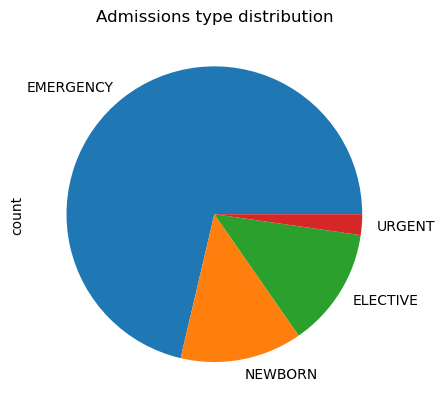

In [17]:
admissions['admission_type'].value_counts().plot(kind = 'pie', title='Admissions type distribution')
plt.show()

Most admissions are due to emergency

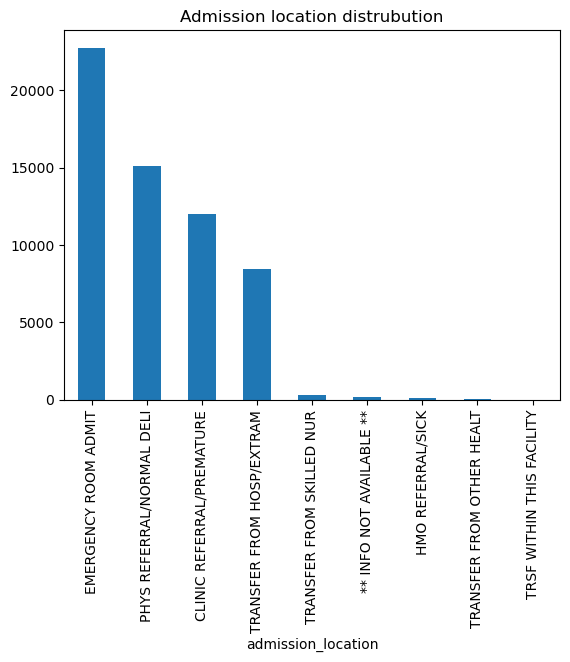

In [18]:
admissions['admission_location'].value_counts().plot(kind = 'bar', title = 'Admission location distrubution')
plt.show()

Most are acute, unscheduled care -- e.g. chest pain, trauma, stroke

HMO: referred by insurance 

#### Sanity check

In [19]:
## check invalid entries -- discharge time is less than admission time 
(admissions['dischtime'] < admissions['admittime']).value_counts()
incorrect_ad_times_mask = admissions['dischtime'] < admissions['admittime']

## print
print(f'Proportion of incorrect disch rel. to admit times: {incorrect_ad_times_mask.mean()*100:.2f}%')

## scrutinise 
admissions[incorrect_ad_times_mask].head()

Proportion of incorrect disch rel. to admit times: 0.17%


,row_id,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_chartevents_data
425,534,417,102633,2177-03-23 16:17:00,2177-03-23 07:20:00,2177-03-23 07:20:00,URGENT,PHYS REFERRAL/NORMAL DELI,DEAD/EXPIRED,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,NaN,NaN,ORGAN DONOR ACCOUNT,1,1
456,237,181,102631,2153-10-12 09:49:00,2153-10-12 06:29:00,2153-10-12 06:29:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,NaN,PROTESTANT QUAKER,MARRIED,WHITE,2153-10-12 06:23:00,2153-10-12 07:45:00,DISSECTING ANEURYSIM,1,1
692,644,516,187482,2197-07-31 20:18:00,2197-07-31 01:10:00,2197-07-31 01:10:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,JEWISH,WIDOWED,UNKNOWN/NOT SPECIFIED,2197-07-31 11:31:00,2197-07-31 14:35:00,RESPIRATORY DISTRESS,1,0
1911,1640,1334,138015,2137-09-02 14:43:00,2137-09-02 12:00:00,2137-09-02 12:00:00,NEWBORN,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,Private,NaN,PROTESTANT QUAKER,NaN,WHITE,NaN,NaN,NEWBORN,1,1
1970,1699,1381,181430,2189-01-02 14:25:00,2189-01-02 12:00:00,2189-01-02 12:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,NaN,UNOBTAINABLE,MARRIED,WHITE,2189-01-02 10:31:00,2189-01-02 15:56:00,STROKE;TELEMETRY,1,1


In [72]:
## Missing ids 

missing_hadm_id = admissions.hadm_id.isna()

print(f'Number of outpatient entries i.e. hospital admission IDs == NANs : {missing_hadm_id.sum()}')

Number of outpatient entries i.e. hospital admission IDs == NANs : 0


There are no outpatient entries in the admissions dataset

In [20]:
## Clean admissions
admissions_cleaned = cleaning_utils.full_clean_admissions(admissions)

(41325, 19)
(2007, 20)
(5785, 20)
(2128, 20)
(54, 20)
ethnicity_categorised
WHITE              41325
BLACK               5785
HISPANIC            2128
ASIAN               2007
AMERICAN INDIAN       54
Name: count, dtype: int64
converting admittime to dt
converting dischtime to dt
converting deathtime to dt
converting edregtime to dt
converting edouttime to dt
Number of incorrect" 98


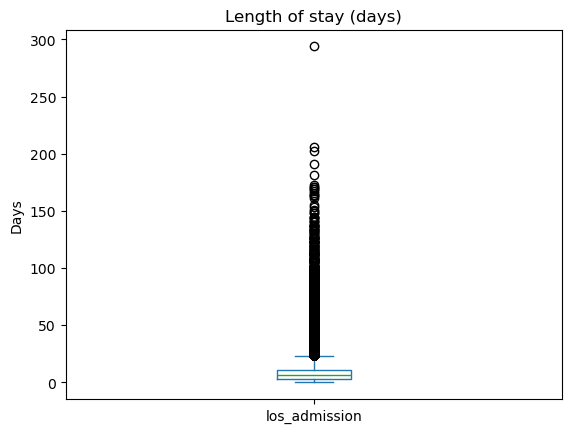

In [21]:
admissions_cleaned.los_admission.dt.days.plot(kind = 'box', title = 'Length of stay (days)', ylabel = 'Days')
plt.show()

In [22]:
## More
admissions_cleaned.los_admission.describe()

count                         58878
mean     10 days 03:37:49.415061653
std      12 days 11:02:04.450875801
min                 0 days 00:02:00
25%                 3 days 18:08:00
50%                 6 days 11:45:00
75%                11 days 19:20:00
max               294 days 15:51:00
Name: los_admission, dtype: object

Most hospital days are at least a few days

In [23]:
## Diseases with longest and shortest admission stays
admissions_cleaned.groupby('diagnosis')['los_admission'].mean().dt.days.sort_values(ascending= False)

diagnosis
CROHN'S DISEASE;ABDOMINAL FISTULA                              294
ASPIRATION; FAILURE TO THRIVE                                  191
CHRONIC LYMPHOCYTIC LEUKEMIA\BONE MARROW TRANSPLANT            169
L THIGH FLUID COLLECTION                                       166
AMC;FEVER                                                      164
                                                              ... 
CEREBRAL PALSY; RECURRENT ASPIRATION PNEUMONIA/SDA               0
SEVER HEAD INJURY                                                0
CEREBRIAL ARTERIOVENOUS MALFORMATION/SDA                         0
CEREBRAL VASCULAR ACCIDENT;RESPIRATORY FAILURE;RAPIDN A-FIB      0
SEPTIC HIP                                                       0
Name: los_admission, Length: 15630, dtype: int64

### 3. Diagnosis

In [24]:
diagnosis

diagnosis_cleaned = cleaning_utils.icd9_chapters(diagnosis)
    

C:\Users\tanip\OneDrive - Agency for Science, Technology and Research\Documents\MIMIC 3\cleaning_utils.py:195: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diagnosis.loc[external_causes_mask.fillna(False), 'icd_group'] = 'External causes'
C:\Users\tanip\OneDrive - Agency for Science, Technology and Research\Documents\MIMIC 3\cleaning_utils.py:196: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diagnosis.loc[supplementary_mask.fillna(False), 'icd_group']   = 'Supplementary factors'


In [25]:
diagnosis_cleaned.head()

,row_id,subject_id,hadm_id,seq_num,icd9_code,icd_group
0,1297,109,172335,1.0,40301,Circulatory
1,1298,109,172335,2.0,486,Respiratory
2,1299,109,172335,3.0,58281,Genitourinary
3,1300,109,172335,4.0,5855,Genitourinary
4,1301,109,172335,5.0,4254,Circulatory


In [26]:
print(f'Average number of diagnoses per admission {diagnosis_cleaned.groupby('hadm_id')['row_id'].count().mean():.1f}') 


Average number of diagnoses per admission 11.0


Understand the dataset: a patient can have one admission but multiple diagnoses
* Hence, subset for the first diagnosis to not cause a one to many

In [27]:
## Check common diseases

## Across all sequence numbers
print('ROW COUNT PER ICD GROUP =========')
print(diagnosis_cleaned.groupby('icd_group')['row_id'].count().sort_values(ascending= False))
print('=='*20)

## Which is usually the main diagnosis (i.e. lower sequence number)
print('AVERAGE SEQ NUMBER =========')
print(diagnosis_cleaned.groupby('icd_group')['seq_num'].mean().sort_values(ascending= True))
print('=='*20)

## Which is the most common disease per sequence number
print('MOST COMMON SEQ NUMBER =========')
print(pd.DataFrame(diagnosis_cleaned.groupby('seq_num')['icd_group'].agg(lambda x: x.value_counts().idxmax())).head())
print('=='*20)



ROW COUNT PER ICD GROUP =========
icd_group
Circulatory              140257
Supplementary factors     74705
Endocrine                 69592
Respiratory               44825
Injury/Poisoning          42948
Digestive                 38527
Genitourinary             32867
Symptoms                  29691
Blood                     25262
Mental                    24876
Nervous                   23334
External causes           22544
Infectious                20264
Perinatal                 20160
Neoplasms                 14235
Musculoskeletal           13392
Skin                       8789
Congenital                 4078
Pregnancy                   654
Others                       47
Name: row_id, dtype: int64
AVERAGE SEQ NUMBER =========
icd_group
Perinatal                 4.513938
Neoplasms                 4.836108
Respiratory               5.249682
Injury/Poisoning          5.506659
Congenital                5.675086
Pregnancy                 6.094801
Genitourinary             6.680896
Circu

# Transform

In [28]:
## Join patients and admissions
patients_admissions = admissions_cleaned.merge(patients, on = 'subject_id', 
                                              suffixes=('_admissions', '_patients'))

patients_admissions = patients_admissions.drop(columns=['row_id' + '_admissions', 'row_id' + '_patients'])

In [29]:
## sanity checks 
print(admissions_cleaned.shape)
print(patients_admissions.shape)

(58878, 21)
(58878, 27)


In [30]:
## Generate some useful columns 

## Create age during admission 
patients_admissions = cleaning_utils.get_age_via_extraction(patients_admissions,'admittime', 'dob', 'age_during_admission')
## Categorise the age into bins 
patients_admissions = cleaning_utils.age_categorise(patients_admissions)


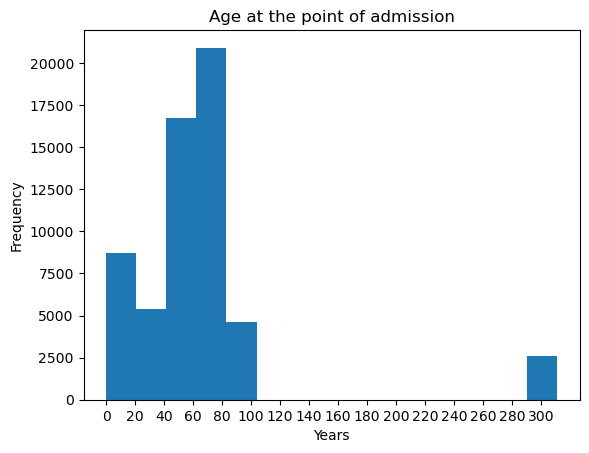

count    58878.000000
mean        64.007405
std         57.184966
min          0.000000
25%         43.000000
50%         61.000000
75%         75.000000
max        311.000000
Name: age_during_admission, dtype: float64

In [31]:
## Check 
patients_admissions.age_during_admission.plot(kind = 'hist', title = 'Age at the point of admission', xlabel = 'Years', 
                                             bins = 15)
plt.xticks(np.arange(0, 300+20, 20))
plt.show()
patients_admissions.age_during_admission.describe()
## Recall that we are seeing age = 300 due to HIPAA requirement for masking the age of those that are 90+

In [32]:
## Closer examination of those of unusually high age 
patients_admissions[patients_admissions.age_during_admission > 200].age_during_admission.value_counts().sort_index()

age_during_admission
300    2259
301     108
302      69
303      47
304      41
305      22
306      26
307      17
308      11
309       4
310       5
311       1
Name: count, dtype: int64

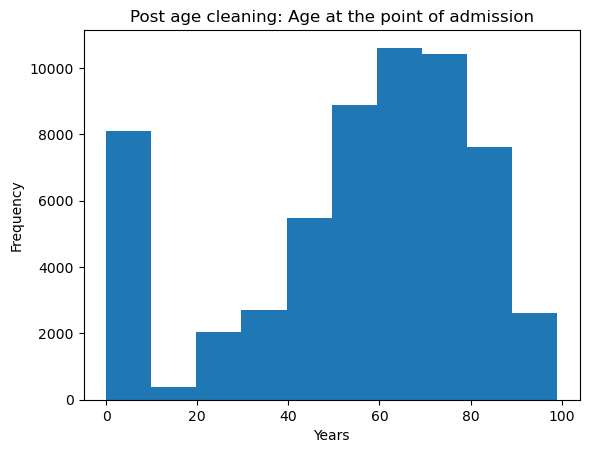

In [33]:
## implement 
patients_admissions = cleaning_utils.pull_back_deid_ages(patients_admissions)

## check ages 
patients_admissions['age_during_admission'].plot(kind = 'hist', title = 'Post age cleaning: Age at the point of admission', xlabel = 'Years')
plt.show()

In [34]:
## add visit order number per patient 
patients_admissions['nth_visit'] = patients_admissions.groupby('SUBJECT_ID'.lower())\
                                    ['ADMITTIME'.lower()].rank(method = 'first').astype(int)
patients_admissions['latest_visit'] = patients_admissions.groupby('SUBJECT_ID'.lower())\
                                    ['ADMITTIME'.lower()].rank(method = 'first', ascending = False).astype(int)
patients_admissions['latest_visit'] = (patients_admissions['latest_visit'] == 1).astype(int)

## check 
example_id = patients_admissions.subject_id.iloc[1]
patients_admissions.loc[patients_admissions.subject_id == example_id, 
                        ['SUBJECT_ID'.lower(),'ADMITTIME'.lower(), 'HADM_ID'.lower(), 'nth_visit', 'latest_visit']]

,subject_id,admittime,hadm_id,nth_visit,latest_visit
1,23,2153-09-03 07:15:00,152223,1,0
2,23,2157-10-18 19:34:00,124321,2,1


### Sanity checks

In [35]:
# Lowercase all column names
patients_admissions.columns = patients_admissions.columns.str.lower()

## since patient can have more than 1 admission, filter for latest_visit
latest_visit_mask = patients_admissions.latest_visit == 1
latest_visit_expire_flag = patients_admissions.loc[latest_visit_mask, 'expire_flag']
latest_visit_hosp_expire_flag = patients_admissions.loc[latest_visit_mask, 'hospital_expire_flag']

## ALL EQUAL?
expire_flags_align = np.all(latest_visit_expire_flag == latest_visit_hosp_expire_flag)
print(f'Do expire flags align (between patients expire flag and admissions expire flag?: {expire_flags_align}')

## check where not equal 
patients_admissions[latest_visit_mask][latest_visit_expire_flag != latest_visit_hosp_expire_flag][[
    'subject_id', 'hadm_id', 'admittime', 'expire_flag', 'hospital_expire_flag', 'dod_consolidated', 'deathtime'
]].head()

Do expire flags align (between patients expire flag and admissions expire flag?: False


,subject_id,hadm_id,admittime,expire_flag,hospital_expire_flag,dod_consolidated,deathtime
5,26,197661,2126-05-06 15:16:00,1,0,2128-02-25,NaT
13,34,144319,2191-02-23 05:23:00,1,0,2192-01-30,NaT
18,37,188670,2183-08-21 16:48:00,1,0,2185-01-06,NaT
21,41,101757,2132-12-31 10:30:00,1,0,2133-09-30,NaT
26,357,117876,2199-12-21 22:37:00,1,0,2201-08-02,NaT


Finding: we see that DEATHTIME (admissions) does not align with date of death (patients) --> it is likely that patients data can be updated post admission, hence a patient could be 'alive' in the admissions df but 'dead' in the patients df 

In [36]:
## Subset for main diagnosis 
main_diagnosis = diagnosis_cleaned[diagnosis_cleaned.seq_num == 1]

## Merge diagnosis 
print(patients_admissions.shape[0])
patients_admissions_diagnosis = patients_admissions.merge(main_diagnosis, on = ['subject_id', 'hadm_id'], how  = 'left')
print(patients_admissions_diagnosis.shape[0])

58878
58878


In [37]:
## Large number of age_during_admission = 0
(patients_admissions.age_during_admission == 0).value_counts()

## Ensure that it makes sense --> check the reasons for admission
neonates_mask = patients_admissions.age_during_admission == 0
patients_admissions[neonates_mask].ADMISSION_TYPE.value_counts().plot(kind = 'bar', title = 'Neonates (age = 0) admission types')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'ADMISSION_TYPE'

In [ ]:
## Merge in PRIMARY DIAGNOSIS ONLY 

primary_diagnosis = diagnosis_cleaned[diagnosis_cleaned.SEQ_NUM == 1].rename({'ICD9_CODE': 'PRI_ICD9', 'icd_group':'pri_icd_group'})
print(primary_diagnosis.shape)

## Merge 
print(f'before: {patients_admissions.shape}')
patients_admissions_diagnosis = patients_admissions.merge(primary_diagnosis, on = 'HADM_ID', suffixes = ('', '_diagnosis'), how = 'left')
print(f'after: {patients_admissions_diagnosis.shape}') ## ensure no loss of admissions information


# Exploring/ Analysis

In [38]:
import duckdb

con = duckdb.connect()

In [39]:
con.register("patients_admissions", patients_admissions)
con.register("patients_admissions_diagnosis", patients_admissions_diagnosis)

## check cols 
patients_admissions.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'ethnicity_categorised', 'los_admission',
       'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag',
       'dod_consolidated', 'age_during_admission', 'age_group', 'nth_visit',
       'latest_visit'],
      dtype='object')

### Explore neonates

### Number of admissions per patient

In [40]:
con.sql('''
    SELECT SUBJECT_ID, count(distinct HADM_ID) as admission_count 
    FROM patients_admissions
    group by SUBJECT_ID
    order by admission_count desc 
''').show()

┌────────────┬─────────────────┐
│ subject_id │ admission_count │
│   int64    │      int64      │
├────────────┼─────────────────┤
│      13033 │              42 │
│      11861 │              34 │
│        109 │              34 │
│       5060 │              31 │
│      20643 │              24 │
│      19213 │              23 │
│       7809 │              22 │
│       5727 │              21 │
│      23657 │              20 │
│      11318 │              19 │
│         ·  │               · │
│         ·  │               · │
│         ·  │               · │
│       2002 │               1 │
│       3781 │               1 │
│       2055 │               1 │
│       2737 │               1 │
│       2535 │               1 │
│       2548 │               1 │
│       3058 │               1 │
│       3567 │               1 │
│       3380 │               1 │
│       3712 │               1 │
├────────────┴─────────────────┤
│ ? rows             2 columns │
│ (>9999 rows, 20 shown)       │
└─────────

In [41]:
## Finding key stats of number of visits per patient 

con.sql('''
with PATIENT_ADM_COUNT AS (
    SELECT SUBJECT_ID, count(distinct HADM_ID) as admission_count 
    FROM patients_admissions
    group by SUBJECT_ID
    order by admission_count desc)
select 
    avg(admission_count) as average_count, 
    max(admission_count) as max_count, 
    min(admission_count) as min_count, 
    mode(admission_count) as mode_count 
FROM PATIENT_ADM_COUNT
''').show()

┌────────────────────┬───────────┬───────────┬────────────┐
│   average_count    │ max_count │ min_count │ mode_count │
│       double       │   int64   │   int64   │   int64    │
├────────────────────┼───────────┼───────────┼────────────┤
│ 1.2676929701797826 │        42 │         1 │          1 │
└────────────────────┴───────────┴───────────┴────────────┘



Most patients only visit once --> however, the most a patient has been admitted is 42 times.

## Most common diseases per ethnicity?

In [42]:
top_diseases_per_ethnicity = patients_admissions_diagnosis.groupby('ethnicity_categorised')['diagnosis'].agg(lambda x: x.value_counts().sort_values(ascending = False).head(5).index)\
        .apply(pd.Series)

top_diseases_per_ethnicity.columns = [f'Top {i}' for i in range(1,6)]

top_diseases_per_ethnicity

,Top 1,Top 2,Top 3,Top 4,Top 5
ethnicity_categorised,,,,,
AMERICAN INDIAN,NEWBORN,CONGESTIVE HEART FAILURE,FEVER,UPPER GASTROINTESTINAL BLEED,PELVIS FRACTURE;FACIAL FRACTURE
ASIAN,NEWBORN,PNEUMONIA,SEPSIS,HYPERBILIRUBINEMIA,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
BLACK,NEWBORN,PNEUMONIA,CONGESTIVE HEART FAILURE,DIABETIC KETOACIDOSIS,SEPSIS
HISPANIC,NEWBORN,PNEUMONIA,SEPSIS,UPPER GI BLEED,DIABETIC KETOACIDOSIS
WHITE,NEWBORN,PNEUMONIA,SEPSIS,CONGESTIVE HEART FAILURE,CHEST PAIN


In [43]:
top_diseases_per_ethnicity = patients_admissions_diagnosis.groupby('ethnicity_categorised')['icd_group'].agg(lambda x: x.value_counts().sort_values(ascending = False).head(5).index)\
        .apply(pd.Series)

top_diseases_per_ethnicity.columns = [f'Top {i}' for i in range(1,6)]

top_diseases_per_ethnicity

,Top 1,Top 2,Top 3,Top 4,Top 5
ethnicity_categorised,,,,,
AMERICAN INDIAN,Supplementary factors,Circulatory,Digestive,Infectious,Respiratory
ASIAN,Supplementary factors,Circulatory,Injury/Poisoning,Neoplasms,Infectious
BLACK,Circulatory,Supplementary factors,Respiratory,Injury/Poisoning,Digestive
HISPANIC,Circulatory,Supplementary factors,Injury/Poisoning,Digestive,Respiratory
WHITE,Circulatory,Injury/Poisoning,Supplementary factors,Digestive,Respiratory


## Mortality rates 

In [44]:
pd.DataFrame(patients_admissions_diagnosis.groupby('icd_group')['hospital_expire_flag'].mean().\
             sort_values(ascending=False).head(10) * 100).round(2)\
            .rename(columns = {'hospital_expire_flag': 'Hospital Mortality Rate (%)'})

,Hospital Mortality Rate (%)
icd_group,
Infectious,25.55
Respiratory,15.38
Blood,13.72
Neoplasms,13.44
Digestive,10.20
Genitourinary,9.99
Injury/Poisoning,9.65
Circulatory,9.35
Nervous,7.96


In [45]:
pd.DataFrame(patients_admissions_diagnosis.groupby('ethnicity_categorised')['hospital_expire_flag'].mean()\
             .sort_values(ascending=False).head(10) * 100).round(2)\
             .rename(columns = {'hospital_expire_flag':'Hospital Mortality Rate (%)'})


,Hospital Mortality Rate (%)
ethnicity_categorised,
WHITE,9.77
ASIAN,7.53
AMERICAN INDIAN,7.41
BLACK,7.20
HISPANIC,5.60


## Age group analysis

In [46]:
pd.DataFrame(patients_admissions_diagnosis.groupby('age_group')['hospital_expire_flag'].mean() * 100).rename(columns = {'HOSPITAL_EXPIRE_FLAG':'Hosp Mortality Rate'})


C:\Users\tanip\AppData\Local\Temp\ipykernel_35808\3434063260.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.DataFrame(patients_admissions_diagnosis.groupby('age_group')['hospital_expire_flag'].mean() * 100).rename(columns = {'HOSPITAL_EXPIRE_FLAG':'Hosp Mortality Rate'})


,hospital_expire_flag
age_group,
<18,0.853450
18-29,4.845626
30-39,5.682657
40-49,7.339785
50-59,8.278892
60-69,9.928410
70-79,12.798161
80+,17.953769


In [47]:
pd.DataFrame(patients_admissions_diagnosis.groupby('age_group')['icd_group'].agg(lambda x: x.value_counts().sort_values(ascending = False).head(3).idxmax()))

C:\Users\tanip\AppData\Local\Temp\ipykernel_35808\2152851486.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.DataFrame(patients_admissions_diagnosis.groupby('age_group')['icd_group'].agg(lambda x: x.value_counts().sort_values(ascending = False).head(3).idxmax()))


,icd_group
age_group,
<18,Supplementary factors
18-29,Injury/Poisoning
30-39,Injury/Poisoning
40-49,Circulatory
50-59,Circulatory
60-69,Circulatory
70-79,Circulatory
80+,Circulatory


In [48]:
pd.DataFrame(patients_admissions_diagnosis.groupby('age_group')['diagnosis'].agg(lambda x: x.value_counts().sort_values(ascending = False).head(3).idxmax()))

C:\Users\tanip\AppData\Local\Temp\ipykernel_35808\544268232.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.DataFrame(patients_admissions_diagnosis.groupby('age_group')['diagnosis'].agg(lambda x: x.value_counts().sort_values(ascending = False).head(3).idxmax()))


,diagnosis
age_group,
<18,NEWBORN
18-29,DIABETIC KETOACIDOSIS
30-39,DIABETIC KETOACIDOSIS
40-49,PNEUMONIA
50-59,PNEUMONIA
60-69,PNEUMONIA
70-79,PNEUMONIA
80+,PNEUMONIA


In [51]:
[col for col in patients_admissions_diagnosis.columns if 'los' in col.lower()]

['los_admission']

In [52]:
patients_admissions_diagnosis['LOS_admission_days'] = patients_admissions_diagnosis['los_admission'].dt.days
pd.DataFrame(patients_admissions_diagnosis.groupby('age_group')['LOS_admission_days'].mean()).rename(columns={'LOS_admission_days':'Average Length of Stay (Days)'})

C:\Users\tanip\AppData\Local\Temp\ipykernel_35808\258926448.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.DataFrame(patients_admissions_diagnosis.groupby('age_group')['LOS_admission_days'].mean()).rename(columns={'LOS_admission_days':'Average Length of Stay (Days)'})


,Average Length of Stay (Days)
age_group,
<18,11.061570
18-29,8.135935
30-39,9.267528
40-49,9.653643
50-59,9.799392
60-69,9.937924
70-79,9.668263
80+,8.828211


In [53]:
patients_admissions_diagnosis.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'ethnicity_categorised', 'los_admission',
       'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag',
       'dod_consolidated', 'age_during_admission', 'age_group', 'nth_visit',
       'latest_visit', 'row_id', 'seq_num', 'icd9_code', 'icd_group',
       'LOS_admission_days'],
      dtype='object')

## Readmission analysis

In [54]:
## find the number of days between each patient's admission 
## then find rows where the days between is less than 30

readmission_30_days = con.sql(
    '''
with admissions_lag as (
    select SUBJECT_ID, HADM_ID, date(ADMITTIME) as ADMITTIME, 
        lag(DATE(ADMITTIME)) OVER (PARTITION BY SUBJECT_ID ORDER BY ADMITTIME) as previous_admit
    FROM patients_admissions_diagnosis
--    where SUBJECT_ID = 13033
    ORDER BY SUBJECT_ID, ADMITTIME desc), 
admissions_subset as (
select *,
    date_diff('day',  previous_admit, ADMITTIME) AS days_between_admit
    from admissions_lag
    where date_diff('day', previous_admit, ADMITTIME) <= 30)
select 
    p.SUBJECT_ID, p.HADM_ID, days_between_admit,
    icd_group, DIAGNOSIS
    from patients_admissions_diagnosis p 
    inner join admissions_subset a on
        p.HADM_ID = a.HADM_ID
        
    ''').df()

In [55]:
readmission_30_days.head()

,subject_id,hadm_id,days_between_admit,icd_group,diagnosis
0,36,122659,12,Injury/Poisoning,CHEST PAIN/SHORTNESS OF BREATH
1,362,150873,18,Injury/Poisoning,SUBDURAL HEMATOMA
2,68,108329,20,Infectious,WEAKNESS
3,103,133550,18,Circulatory,SUBARACHNOID HEMORRHAGE
4,105,128744,24,Symptoms,FEVER


### Most common ICD group

In [56]:
print(readmission_30_days.icd_group.value_counts().head(10))

icd_group
Circulatory         576
Injury/Poisoning    375
Respiratory         372
Digestive           291
Infectious          249
Perinatal           179
Endocrine            98
Neoplasms            81
Genitourinary        60
Nervous              48
Name: count, dtype: int64


### Most common diagnosis

In [58]:
print(readmission_30_days.diagnosis.value_counts().head(10))

diagnosis
PNEUMONIA                   125
CONGESTIVE HEART FAILURE     95
HYPERBILIRUBINEMIA           95
SEPSIS                       84
FEVER                        57
ALTERED MENTAL STATUS        56
HYPOTENSION                  48
ABDOMINAL PAIN               44
UPPER GI BLEED               42
PREMATURITY                  42
Name: count, dtype: int64


### Most immediate readmission 

In [60]:
readmission_30_days.groupby('diagnosis')['days_between_admit'].mean().sort_values(ascending = True).head(10)

diagnosis
DONOR ACCOUNT                      0.000000
AORTIC STENOSIS                    1.000000
INTERMEDIATE CARE                  1.000000
PERFORATED ANUS                    2.000000
ETOH WITHDRAWL                     2.000000
ALTERED MENTAL STATUS; DYSPNEA     2.000000
ORGAN DONOR ACCOUNT                2.925926
HYPERBILIRUBINEMIA;PHOTOTHERAPY    3.000000
ELEVATED BILIRUBIN                 3.000000
HEADACHE;SUBDURAL HEMORRHAGE       3.000000
Name: days_between_admit, dtype: float64

# Save and store the cleaned data 

In [61]:
import os 

os.makedirs('data/cleaned', exist_ok=True)
os.makedirs('data/curated', exist_ok=True)

In [62]:
## Clean data 
patients_cleaned.to_parquet("data/cleaned/patients_cleaned.parquet")
admissions_cleaned.to_parquet("data/cleaned/admissions_cleaned.parquet")
diagnosis_cleaned.to_parquet("data/cleaned/diagnosis_cleaned.parquet")

## Combined/transformed data 
patients_admissions.to_parquet("data/curated/patients_admissions.parquet")
patients_admissions_diagnosis.to_parquet("data/curated/patients_adm_diag.parquet")


In [65]:
print('SCRIPT DONE')
import datetime 
print(datetime.datetime.now())

SCRIPT DONE
2025-12-10 12:59:29.745249


In [66]:
## check
pd.read_parquet("data/curated/patients_admissions.parquet").columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'ethnicity_categorised', 'los_admission',
       'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag',
       'dod_consolidated', 'age_during_admission', 'age_group', 'nth_visit',
       'latest_visit'],
      dtype='object')

In [67]:
pd.read_parquet("data/curated/patients_adm_diag.parquet").columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'religion', 'marital_status', 'ethnicity',
       'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag',
       'has_chartevents_data', 'ethnicity_categorised', 'los_admission',
       'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag',
       'dod_consolidated', 'age_during_admission', 'age_group', 'nth_visit',
       'latest_visit', 'row_id', 'seq_num', 'icd9_code', 'icd_group',
       'LOS_admission_days'],
      dtype='object')